# Exercise 6 + Homework 3: MLPs + Dropout + CNNs

## ISHA CHATURVEDI - ic1018@nyu.edu

Much of this was taken from DS-GA 1011 course from last semester.

### Data things

We're doing a sentiment classification task. So first load the Stanford Sentiment Treebank data.

## The cells in notebook are run according to the Question sequences in the homework.

### If the cells are run according to the current cell no. they have, it will show how many times each model was run to achieve the desired accuracy.

In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import re
import random

random.seed(1)
sst_home = 'data/trees'

# Let's do 2-way positive/negative classification instead of 5-way
easy_label_map = {0:0, 1:0, 2:None, 3:1, 4:1}
    # so labels of 0 and 1 in te 5-wayclassificaiton are 0 in the 2-way. 3 and 4 are 1, and 2 is none
    # because we don't have a neautral class. 

PADDING = "<PAD>"
UNKNOWN = "<UNK>"
max_seq_length = 20

def load_sst_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data
     
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

And extract bag-of-words feature vectors. For speed, we'll only use words that appear at least 25 times in the training set, leaving us with |V|=1254.

In [3]:
import collections
import numpy as np

def tokenize(string):
    return string.split()

def build_dictionary(training_datasets):
    """
    Extract vocabulary and build dictionary.
    """  
    word_counter = collections.Counter()
    for i, dataset in enumerate(training_datasets):
        for example in dataset:
            word_counter.update(tokenize(example['text']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))

    return word_indices, len(vocabulary)

def sentences_to_padded_index_sequences(word_indices, datasets):
    """
    Annotate datasets with feature vectors. Adding right-sided padding. 
    """
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['text_index_sequence'] = torch.zeros(max_seq_length)

            token_sequence = tokenize(example['text'])
            padding = max_seq_length - len(token_sequence)

            for i in range(max_seq_length):
                if i >= len(token_sequence):
                    index = word_indices[PADDING]
                    pass
                else:
                    if token_sequence[i] in word_indices:
                        index = word_indices[token_sequence[i]]
                    else:
                        index = word_indices[UNKNOWN]
                example['text_index_sequence'][i] = index

            example['text_index_sequence'] = example['text_index_sequence'].long().view(1,-1)
            example['label'] = torch.LongTensor([example['label']])


word_to_ix, vocab_size = build_dictionary([training_set])
sentences_to_padded_index_sequences(word_to_ix, [training_set, dev_set, test_set])

We want to feed data to our model in mini-batches so we need a data iterator that will "batchify" the data. We 

In [4]:
# This is the iterator we'll use during training. 
# It's a generator that gives you one batch at a time.
def data_iter(source, batch_size):
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while True:
        start += batch_size
        if start > dataset_size - batch_size:
            # Start another epoch.
            start = 0
            random.shuffle(order)   
        batch_indices = order[start:start + batch_size]
        yield [source[index] for index in batch_indices]

# This is the iterator we use when we're evaluating our model. 
# It gives a list of batches that you can then iterate through.
def eval_iter(source, batch_size):
    batches = []
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while start < dataset_size - batch_size:
        start += batch_size
        batch_indices = order[start:start + batch_size]
        batch = [source[index] for index in batch_indices]
        batches.append(batch)
        
    return batches

# The following function gives batches of vectors and labels, 
# these are the inputs to your model and loss function
def get_batch(batch):
    vectors = []
    labels = []
    for dict in batch:
        vectors.append(dict["text_index_sequence"])
        labels.append(dict["label"])
    return vectors, labels


### Model time!

We need to define an evaluation function,

In [5]:
def evaluate(model, data_iter):
    model.eval()
    correct = 0
    total = 0
    for i in range(len(data_iter)):
        vectors, labels = get_batch(data_iter[i])
        vectors = Variable(torch.stack(vectors).squeeze())
        labels = torch.stack(labels).squeeze()
        output = model(vectors)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    return correct / float(total)

Below is a multilayer perceptron classifier.

What hyperparameters do you think would work well?

In [6]:
# A Multi-Layer Perceptron (MLP)
class MLPClassifier(nn.Module): # inheriting from nn.Module!
    
    def __init__(self, input_size, embedding_dim, hidden_dim, num_labels, dropout_prob):
        super(MLPClassifier, self).__init__()
        
        self.embed = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(p=dropout_prob)
            
        self.linear_1 = nn.Linear(embedding_dim, hidden_dim) 
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_3 = nn.Linear(hidden_dim, num_labels)
        self.init_weights()
        
    def forward(self, x):
        # Pass the input through your layers in order
        out = self.embed(x)
        out = self.dropout(out)
        out = torch.sum(out, dim=1)
        out = F.relu(self.linear_1(out))
        out = F.relu(self.linear_2(out))
        out = self.dropout(self.linear_3(out))
        return out

    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.linear_1, self.linear_2]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

We now define our training loop,

In [29]:
def training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter):
    step = 0
    for i in range(num_train_steps):
        model.train()
        vectors, labels = get_batch(next(training_iter))
        vectors = Variable(torch.stack(vectors).squeeze())
        labels = Variable(torch.stack(labels).squeeze())

        model.zero_grad()
        output = model(vectors)

        lossy = loss(output, labels)
        lossy.backward()
        optimizer.step()

        if step % 100 == 0:
            dev_accuracy = evaluate(model, dev_iter)
            print( "Step %i; Loss %f; Train acc: %f; Dev acc %f" 
                %(step, lossy.data[0], evaluate(model, train_eval_iter), dev_accuracy ))
        
        step += 1
    accuracy = dev_accuracy 
    return accuracy

Let's define our hyperparameters

In [30]:
# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

Modify these hyperparameters to try to achieve approximately 80% dev accuracy.

In [41]:
hidden_dim = 10
embedding_dim = 10
learning_rate = 0.02
dropout_prob = 0.4

Finally, we can build and train our model!

In [43]:
#Question 5 - MLP

#I ran this piece of code (model) atleast 4 times to achieve 80% accuracy,
#however the accuracy is quite variable

model = MLPClassifier(input_size, embedding_dim, hidden_dim, num_labels, dropout_prob)
    
# Loss and Optimizer
loss = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
training_iter = data_iter(training_set, batch_size)
train_eval_iter = eval_iter(training_set[0:500], batch_size)
dev_iter = eval_iter(dev_set[0:500], batch_size)
training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter)

Step 0; Loss 0.659340; Train acc: 0.514000; Dev acc 0.528000
Step 100; Loss 0.657085; Train acc: 0.732000; Dev acc 0.740000
Step 200; Loss 0.497715; Train acc: 0.842000; Dev acc 0.758000
Step 300; Loss 0.448022; Train acc: 0.866000; Dev acc 0.788000
Step 400; Loss 0.575393; Train acc: 0.922000; Dev acc 0.802000
Step 500; Loss 0.419449; Train acc: 0.936000; Dev acc 0.792000
Step 600; Loss 0.296221; Train acc: 0.946000; Dev acc 0.776000
Step 700; Loss 0.240757; Train acc: 0.946000; Dev acc 0.766000
Step 800; Loss 0.300400; Train acc: 0.944000; Dev acc 0.754000
Step 900; Loss 0.202864; Train acc: 0.960000; Dev acc 0.752000


0.752

Let's see how it performs on the held out test set,

In [44]:
# Test the model
test_iter = eval_iter(test_set, batch_size)
test_acc = evaluate(model, test_iter)
print('Accuracy of the CBOW on the test data: %f' % (test_acc))

Accuracy of the CBOW on the test data: 0.763866


<br>
This model does okay. It doesn't do that well. Lets try and define a Convolutional Neural Network to try and improve performance.

In [17]:
class TextCNN(nn.Module):
    def __init__(self, input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob):
        super(TextCNN, self).__init__()
        
        self.embed = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.dropout2 = nn.Dropout(p = dropout_prob)
        self.conv1 = nn.Conv2d(1, n_filters, (window_size, embedding_dim)) 
        self.fc1 = nn.Linear(n_filters, num_labels)
        self.init_weights()
        
    def forward(self, x):
        # Pass the input through your layers in order
        out = self.embed(x)
        out = self.dropout(out)
        out = out.unsqueeze(1)
        out = self.conv1(out).squeeze(3)
        out = F.relu(out)
        out = F.max_pool1d(out, out.size(2)).squeeze(2)
        out = self.fc1(self.dropout2(out))
        return out

    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.fc1]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

Lets train our Conv Net. Lets redefine the hyperparameters here. You need to modify these as well! Try to achieve approximately 80% dev accuracy.

In [45]:
window_size = 4
n_filters = 8
embedding_dim = 20
learning_rate = 0.0025
dropout_prob = 0.005

Lets build and train this model:

In [47]:
#Question 6 - CNN

#I ran this piece of code (model) atleast 3 times to achieve 80% accuracy.
# As the 80% accuracy is achieved after 400 steps or so, the model should have
#pre-stopping, however this accuracy varies a lot everytime its run.

cnn_model = TextCNN(input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob)
    
# Loss and Optimizer
loss = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

# Train the model
training_iter = data_iter(training_set, batch_size)
train_eval_iter = eval_iter(training_set[0:500], batch_size)
dev_iter = eval_iter(dev_set[0:500], batch_size)
training_loop(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter)

Step 0; Loss 0.693565; Train acc: 0.476000; Dev acc 0.478000
Step 100; Loss 0.691692; Train acc: 0.526000; Dev acc 0.532000
Step 200; Loss 0.652329; Train acc: 0.706000; Dev acc 0.728000
Step 300; Loss 0.421007; Train acc: 0.844000; Dev acc 0.778000
Step 400; Loss 0.487870; Train acc: 0.916000; Dev acc 0.780000
Step 500; Loss 0.186163; Train acc: 0.954000; Dev acc 0.796000
Step 600; Loss 0.145933; Train acc: 0.970000; Dev acc 0.800000
Step 700; Loss 0.042343; Train acc: 0.990000; Dev acc 0.818000
Step 800; Loss 0.037375; Train acc: 0.996000; Dev acc 0.798000
Step 900; Loss 0.014601; Train acc: 0.996000; Dev acc 0.800000


0.8

Lets evaluate this on the held out test set

In [48]:
# Test the model
test_iter = eval_iter(test_set, batch_size)
test_acc = evaluate(cnn_model, test_iter)
print('Accuracy of the CNN model on the test data: %f' % (test_acc))

Accuracy of the CNN model on the test data: 0.761120


# Homework 3 (10pts)

### Please construct all of your plots in the ipython notebook using something like matplotlib. Provide all answers in the ipython notebook. We will not grade anything other than the ipython notebook

Questions:

1. Provide plots of varying hidden_dim, embedding_dim, LR, and dropout for deep CBOW (0.75pts each). 
2. Describe how each hyperparameter affects performance on train and dev (1.5pts total).
3. Provide plots of varying embedding_dim, window_size, num_filters, LR, and dropout for CNN (0.6pts for each HP).
4. Describe how each hyperparameter affects performance on train and dev (1.5pts total).
5. Write down an hyperparameter configuration for CBOW that achieves 80 dev within the first 1000 train steps. Make sure this configuration is run in your ipython notebook when it is submitted (0.5pts).
6. Write down an hyperparameter configuration for CNN that achieves 80 dev within the first 1000 train steps. Make sure this configuration is run in your ipython notebook when it is submitted (0.5pts).

## Question 1 and 2.

In [7]:
#Defining a seperate function for plotting the graphs so that it doesn't interfere
#with the previously defined function

#This function returns the final accuracy after 1000 steps. 

#The function will be used for both MLP and CNN

def training_loop_plot(model, loss, optimizer, training_iter, dev_iter, train_eval_iter):
    step = 0
    for i in range(num_train_steps):
        model.train()
        vectors, labels = get_batch(next(training_iter))
        vectors = Variable(torch.stack(vectors).squeeze())
        labels = Variable(torch.stack(labels).squeeze())

        model.zero_grad()
        output = model(vectors)

        lossy = loss(output, labels)
        lossy.backward()
        optimizer.step()

        if step % 100 == 0:
            dev_accuracy = evaluate(model, dev_iter)
            train_accuracy = evaluate(model, train_eval_iter)
#             print( "Step %i; Loss %f; Train acc: %f; Dev acc %f" 
#                 %(step, lossy.data[0], evaluate(model, train_eval_iter), dev_accuracy ))
        
        step += 1
    
    return dev_accuracy, train_accuracy

In [8]:
#This function is for testing varying hyperparameters for MLP

def test_hyperparams(input_size, embedding_dim, hidden_dim, num_labels, dropout_prob, learning_rate, batch_size):
    model = MLPClassifier(input_size, embedding_dim, hidden_dim, num_labels, dropout_prob)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    dev_accuracy, train_accuracy = training_loop_plot(model, loss, optimizer, training_iter, dev_iter, train_eval_iter)
    return dev_accuracy, train_accuracy

Text(0,0.5,'Accuracy Score for Development Set')

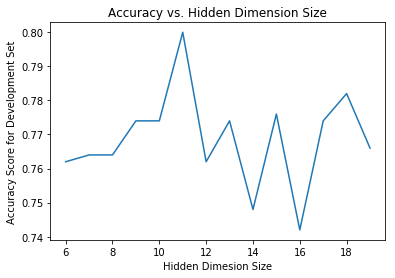

In [9]:
#Varying Hidden Dimensions here for MLP

# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

# hidden_dim = 10
embedding_dim = 10
learning_rate = 0.02
dropout_prob = 0.4

hidden_dims = np.arange(6, 20)
t = torch.from_numpy(hidden_dims)
dev_accuracy, train_accuracy = zip(*[
    # this returns the accuracy
    test_hyperparams(input_size, embedding_dim, hidden_dim_i, 
                     num_labels, dropout_prob, learning_rate, batch_size)
    for hidden_dim_i in t
])

plt.plot(hidden_dims, dev_accuracy)
plt.title('Accuracy vs. Hidden Dimension Size')
plt.xlabel('Hidden Dimesion Size')
plt.ylabel('Accuracy Score for Development Set')


Text(0,0.5,'Accuracy Score for Training Set')

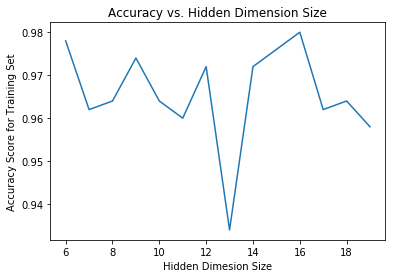

In [10]:
plt.plot(hidden_dims, train_accuracy)
plt.title('Accuracy vs. Hidden Dimension Size')
plt.xlabel('Hidden Dimesion Size')
plt.ylabel('Accuracy Score for Training Set')

### Figure 1. 
This figure shows the accuracy of development set and training set respectively with varying Hidden Dimension for MLP(6 - 19).

Here both development and training accuracies fluctuate a lot with varying hidden dimensions.

For Development set the peak is at Hidden Dimension Size = 11, after which it starts to decrease. There is definitely an increasing trend of the dev accuracy from 6 to 11 hidden dimension size.

For Training set, the lowest train accuracy is at Hidden Dimension Size = 13, and the highest is for 16. To achieve 80% accuracy on the dev set, I have taken size to be 10 (question 5), the accuracy of which looks reasonabily high for both the both the sets here in this graph.

The accuracy on the dev set shows that having a very high hidden dimension size, will make the neural network too complex and alow, and will detiorate the dev accuracy.

Text(0,0.5,'Accuracy Score for Development Set')

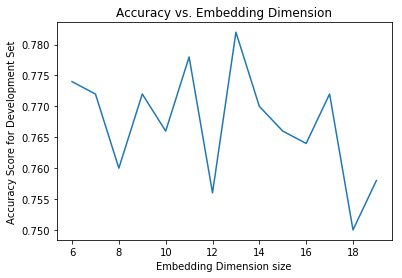

In [11]:
#Varying Embedding Dimensions here for MLP


# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

hidden_dim = 10
# embedding_dim = 10
learning_rate = 0.02
dropout_prob = 0.4

embedding_dims = np.arange(6, 20)
edim = torch.from_numpy(embedding_dims)
dev_accuracy, train_accuracy = zip(*[
    # this returns the accuracy
    test_hyperparams(input_size, e_dim_i, hidden_dim, 
                     num_labels, dropout_prob, learning_rate, batch_size)
    for e_dim_i in edim
])

plt.plot(embedding_dims, dev_accuracy)
plt.title('Accuracy vs. Embedding Dimension')
plt.xlabel('Embedding Dimension size')
plt.ylabel('Accuracy Score for Development Set')


Text(0,0.5,'Accuracy Score for Training Set')

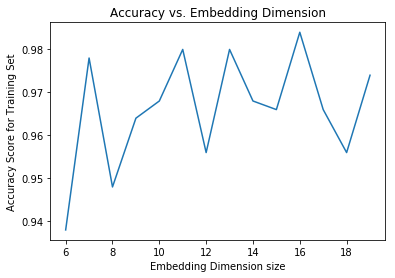

In [12]:
plt.plot(embedding_dims, train_accuracy)
plt.title('Accuracy vs. Embedding Dimension')
plt.xlabel('Embedding Dimension size')
plt.ylabel('Accuracy Score for Training Set')

### Figure 2. 
This figure shows the accuracy of development set and training set respectively with varying Embedding Dimension for MLP(6 - 19).


Here both development and training accuracies fluctuate a lot with varying Embedding Dimensions.

For Development set the peak is at Embedding Dimension Size = 13, after which it starts to decrease. There is no definite trend of the dev accuracy here.

For Training set, the highest train accuracy is at Embedding Dimension Size = 16. To achieve 80% accuracy on the dev set, I have taken size to be 10 (question 5), the accuracy of which looks reasonabily high for both the both the sets here in this graph.

The accuracy on the dev set shows that having a very high embedding dimension size, will make the neural network too complex and alow, and will detiorate the dev accuracy.


Text(0,0.5,'Accuracy Score for Development Set')

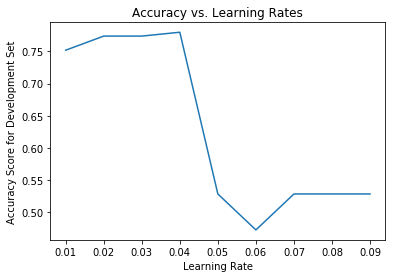

In [13]:
#Varying Learning Rate here

# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

hidden_dim = 10
embedding_dim = 10
# learning_rate = 0.02
dropout_prob = 0.4

learning_rates = np.arange(0.01, 0.1,0.01)
# lr = torch.FloatStorage(0.01, 0.05)
dev_accuracy, train_accuracy = zip(*[
    # this returns the accuracy
    test_hyperparams(input_size, embedding_dim, hidden_dim, 
                     num_labels, dropout_prob, lr_i, batch_size)
    for lr_i in learning_rates
])

plt.plot(learning_rates, dev_accuracy)
plt.title('Accuracy vs. Learning Rates')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Score for Development Set')


Text(0,0.5,'Accuracy Score for Training Set')

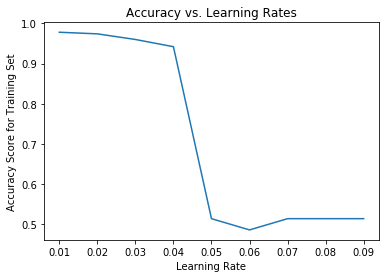

In [14]:
plt.plot(learning_rates, train_accuracy)
plt.title('Accuracy vs. Learning Rates')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Score for Training Set')

### Figure 3.
This figure shows the accuracy of development set and training set respectively with varying Learning Rate for MLP(0.01 - 0.09).


Here, both development and training accuracies shows a similar trend with varying Learning rates. Further, we can see that accuracies for both the sets are higher when the learning rate is low. The accuracy deteriotates a lot after learning rate 0.04.

Hence, it shows that slower the learning rate, the better is the accuracy. To achieve 80% dev accuracy (question 5), I have taken learning rate = 0.02.

Text(0,0.5,'Accuracy Score for Development Set')

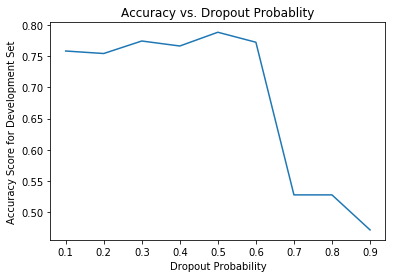

In [15]:
#Varying Dropout Probability here

# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

hidden_dim = 10
embedding_dim = 10
learning_rate = 0.02
# dropout_prob = 0.4

dropout_prob = np.arange(0.1, 1.0,0.1)
# lr = torch.FloatStorage(0.01, 0.05)
dev_accuracy, train_accuracy = zip(* [
    # this returns the accuracy
    test_hyperparams(input_size, embedding_dim, hidden_dim, 
                     num_labels, drop_i, learning_rate, batch_size)
    for drop_i in dropout_prob
])

plt.plot(dropout_prob, dev_accuracy)
plt.title('Accuracy vs. Dropout Probablity')
plt.xlabel('Dropout Probability')
plt.ylabel('Accuracy Score for Development Set')

Text(0,0.5,'Accuracy Score for Training Set')

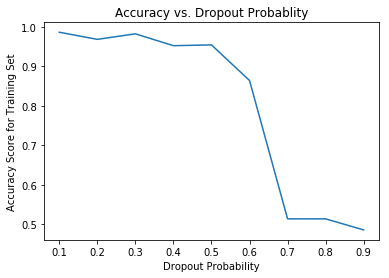

In [16]:
plt.plot(dropout_prob, train_accuracy)
plt.title('Accuracy vs. Dropout Probablity')
plt.xlabel('Dropout Probability')
plt.ylabel('Accuracy Score for Training Set')

### Figure 4.
This figure shows the accuracy of development set and training set respectively with varying Dropout Probability for MLP(0.1 - 0.9).

The trends for dropout probability is a bit similar to that of learning rate. Both the development and training accuracies shows a similar trend with varying dropout probabilities. 
We can see that accuracies for both the sets are relatively higher when the dropout probability is low. The accuracy deteriotates a lot after dropout probability 0.06.

To achieve 80% dev accuracy (question 5), I have taken dropout_prob = 0.4.

## Question 3 and 4.

In [18]:
#This function is for testing varying hyperparameters for CNN

def test_hyperparams_CNN(input_size, embedding_dim, window_size, n_filters,num_labels,
                         dropout_prob,batch_size,num_train_steps, learning_rate):
    
    cnn_model = TextCNN(input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob)
    
 
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    
    dev_accuracy, train_accuracy = training_loop_plot(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter)
    
    return dev_accuracy, train_accuracy

Text(0,0.5,'Accuracy Score for Development Set')

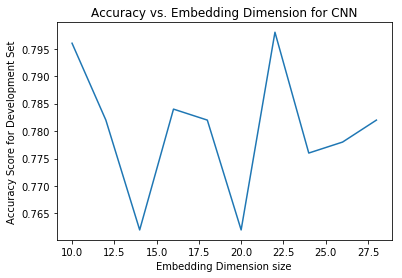

In [19]:
#Varying Embedding Dimensions here

# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

window_size = 4
n_filters = 8
#embedding_dim = 20
learning_rate = 0.0025
dropout_prob = 0.005

embedding_dims = np.arange(10,30,2)
edim = torch.from_numpy(embedding_dims)
dev_accuracy, train_accuracy = zip(*[
    # this returns the accuracy
    test_hyperparams_CNN(input_size, e_dim_i, window_size, n_filters,num_labels,
                         dropout_prob,batch_size,num_train_steps, learning_rate)
    for e_dim_i in edim
])

plt.plot(embedding_dims, dev_accuracy)
plt.title('Accuracy vs. Embedding Dimension for CNN')
plt.xlabel('Embedding Dimension size')
plt.ylabel('Accuracy Score for Development Set')


Text(0,0.5,'Accuracy Score for Training Set')

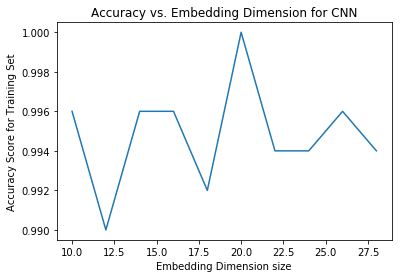

In [20]:
plt.plot(embedding_dims, train_accuracy)
plt.title('Accuracy vs. Embedding Dimension for CNN')
plt.xlabel('Embedding Dimension size')
plt.ylabel('Accuracy Score for Training Set')


### Figure 5.
This figure shows the accuracy of development set and training set respectively with varying Embedding Dimension for CNN(10 - 29, with a gap of 2).

Here both development and training accuracies fluctuate a lot with varying embedding dimension size.

For Development set the peak is at Embedding Dimension Size = 21, after which it starts to decrease. There is no definite trend of the dev accuracy here.

For Training set, the highest train accuracy is at Embedding Dimension Size = 21, 

To achieve 80% accuracy on the dev set, I have taken size to be 20 (question 6), the accuracy of which looks reasonabily high for both the both the sets here in this graph.

Here we can definitely see, that CNN requires higher Embedding Dimension (around 20 or more) than MLP(around 10).

Text(0,0.5,'Accuracy Score for Development Set')

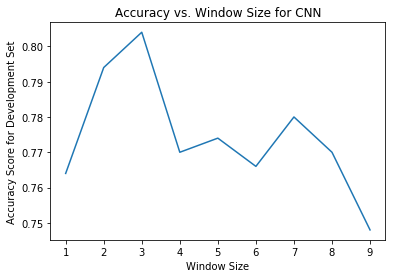

In [21]:
#Varying Window Size here

# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

#window_size = 4
n_filters = 8
embedding_dim = 20
learning_rate = 0.0025
dropout_prob = 0.005

window_size = np.arange(1,10)
wsize = torch.from_numpy(window_size)
dev_accuracy, train_accuracy = zip(*[
    # this returns the accuracy
    test_hyperparams_CNN(input_size, embedding_dim, wsize_i, n_filters,num_labels,
                         dropout_prob,batch_size,num_train_steps, learning_rate)
    for wsize_i in wsize
])

plt.plot(window_size, dev_accuracy)
plt.title('Accuracy vs. Window Size for CNN')
plt.xlabel('Window Size')
plt.ylabel('Accuracy Score for Development Set')

Text(0,0.5,'Accuracy Score for Training Set')

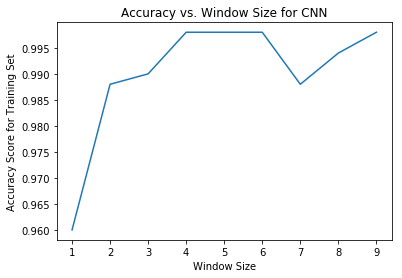

In [22]:
plt.plot(window_size, train_accuracy)
plt.title('Accuracy vs. Window Size for CNN')
plt.xlabel('Window Size')
plt.ylabel('Accuracy Score for Training Set')

### Figure 6.
This figure shows the accuracy of development set and training set respectively with varying Window Size for CNN(1 - 9).


Here both development and training accuracies fluctuate a lot with varying window sizes.

For Development set the peak is at window Size = 3, after which it starts to decrease. There is definitely a decreasing trend of the dev accuracy after window size 3.

For Training set, the highest train accuracy is from window size 4 to 6. To achieve 80% accuracy on the dev set, I have taken size to be 4 (question 6). 

I am still wondering why the dev accuracy wasn't high when I chose the window size 3 (in ques 6).

The accuracy on the dev set shows that having a very high window size, will decrease the performance accuracy of the CNN.

Text(0,0.5,'Accuracy Score for Development Set')

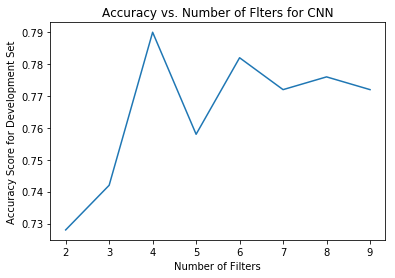

In [23]:
#Varying Number of Filters here

# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

window_size = 4
#n_filters = 8
embedding_dim = 20
learning_rate = 0.0025
dropout_prob = 0.005

n_filters  = np.arange(2,10)
nfil = torch.from_numpy(n_filters)
dev_accuracy, train_accuracy = zip(*[
    # this returns the accuracy
    test_hyperparams_CNN(input_size, embedding_dim, window_size, nfil_i, num_labels,
                         dropout_prob,batch_size,num_train_steps, learning_rate)
    for nfil_i in nfil
])

plt.plot(n_filters, dev_accuracy)
plt.title('Accuracy vs. Number of Flters for CNN')
plt.xlabel('Number of Filters')
plt.ylabel('Accuracy Score for Development Set')

Text(0,0.5,'Accuracy Score for Training Set')

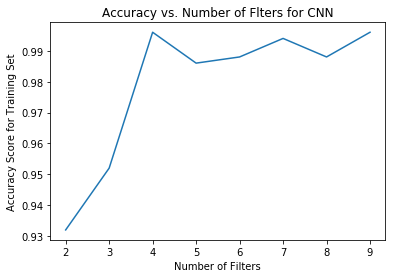

In [24]:
plt.plot(n_filters, train_accuracy)
plt.title('Accuracy vs. Number of Flters for CNN')
plt.xlabel('Number of Filters')
plt.ylabel('Accuracy Score for Training Set')

### Figure 7.
This figure shows the accuracy of development set and training set respectively with varying Number of Filters for CNN(2 - 9).

The trends for dropout probability show that the accuracy dereases after a certain number of filters. 
We can see that accuracies for both the sets are relatively higher when the dropout number of filters are low, however this trend fluctuates a lot on the dev set.

To achieve 80% dev accuracy (question 5), I have taken number of filters = 0.8.

Text(0,0.5,'Accuracy Score for Development Set')

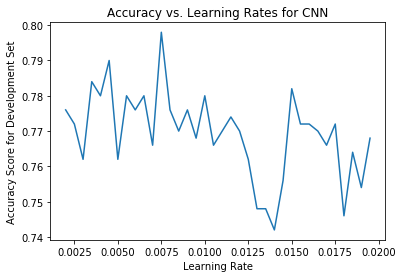

In [25]:
#Varying Learning Rate here

# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

window_size = 4
n_filters = 8
embedding_dim = 20
#learning_rate = 0.0025
dropout_prob = 0.005

learning_rates  = np.arange(0.002,0.02,0.0005)
lr = torch.from_numpy(learning_rates)
dev_accuracy, train_accuracy = zip(*[
    # this returns the accuracy
    test_hyperparams_CNN(input_size, embedding_dim, window_size, n_filters, num_labels,
                         dropout_prob,batch_size,num_train_steps, lr_i)
    for lr_i in lr
])

plt.plot(learning_rates, dev_accuracy)
plt.title('Accuracy vs. Learning Rates for CNN')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Score for Development Set')

Text(0,0.5,'Accuracy Score for Training Set')

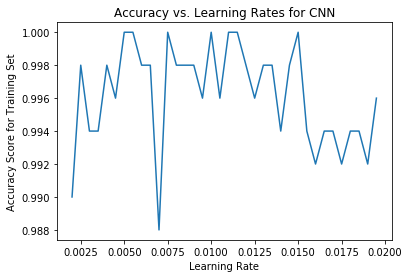

In [26]:
plt.plot(learning_rates, train_accuracy)
plt.title('Accuracy vs. Learning Rates for CNN')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Score for Training Set')

### Figure 8.
This figure shows the accuracy of development set and training set respectively with varying Learning Rate for CNN(0.002 - 0.0195, with a gap of 0.0005).

Here both development and training accuracies fluctuate a lot with varying learning rate, and there seems to be no definite trend, however the accuracy on the dev set decreases, once the learning rate shoots up to above 0.0075.

Text(0,0.5,'Accuracy Score for Development Set')

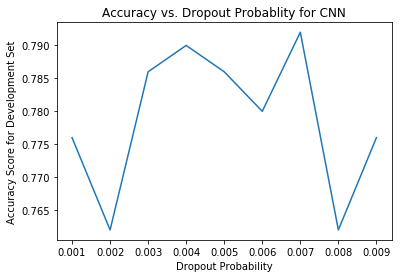

In [27]:
#Varying dropout probability here

# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

window_size = 4
n_filters = 8
embedding_dim = 20
learning_rate = 0.0025
#dropout_prob = 0.005

dropout_prob  = np.arange(0.001,0.01,0.001)
drop_prob= torch.from_numpy(dropout_prob )
dev_accuracy, train_accuracy = zip(*[
    # this returns the accuracy
    test_hyperparams_CNN(input_size, embedding_dim, window_size, n_filters, num_labels,
                         drop_i, batch_size,num_train_steps,learning_rate)
    for drop_i in drop_prob
])

plt.plot(dropout_prob, dev_accuracy)
plt.title('Accuracy vs. Dropout Probablity for CNN')
plt.xlabel('Dropout Probability')
plt.ylabel('Accuracy Score for Development Set')

Text(0,0.5,'Accuracy Score for Training Set')

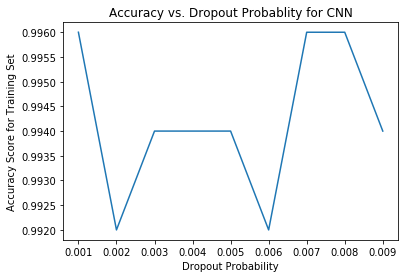

In [28]:
plt.plot(dropout_prob, train_accuracy)
plt.title('Accuracy vs. Dropout Probablity for CNN')
plt.xlabel('Dropout Probability')
plt.ylabel('Accuracy Score for Training Set')

### Figure 9.
This figure shows the accuracy of development set and training set respectively with varying Dropout Probability for CNN(0.001 - 0.009, with a gap of 0.001).

Here both development and training accuracies fluctuate a lot with varying Dropout Probability, and there is no definite trend.

## Question 5 (80% accuracy for MLP).

Referring to Cell no. 41 and 43:

I ran the model atleast 2 times to achieve 80% accuracy.

Configuration: 

hidden_dim = 10
embedding_dim = 10
learning_rate = 0.02
dropout_prob = 0.4

However the dev accuracy varies a lot, everytime I run the model all over again from the start, but I managed to get 80% dev accuracy most of the times with this configuration - provided I ran it over 2 - 4 times. As the model achieves 80% dev accuracy after 400 steps or so here, it should have pre-stopping, however this is quite variable.

## Question 6 (80% accuracy for NLU).

Referring to Cell no. 45 and 47:

I ran the model atleast 2 times to achieve 80% dev accuracy.

Configuration: 

window_size = 4
n_filters = 8
embedding_dim = 20
learning_rate = 0.0025
dropout_prob = 0.005

However the accuracy varies a lot, everytime I run the model all over again from the start, but I managed to get 80% dev accuracy most of the times with this configuration - provided I ran it over 2 - 4 times. Sometimes the model achieves 80% dev accuracy before 1000 steps (for example here at 600 steps), and thus pre-stopping might be needed, but this varies a lot.